# Explorary Analysis


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pylab as plt
from collections import Counter

## Objective 
- Develop a classifier that can determine from name alone whether an entity entered by its users is one of 14 difference classes. 
- the classifier should be trained to categorise an unseen name/entity. 


In [141]:

def read_classes_as_dict_lookup(filepath='./data/classes.txt'):
    """
    Reads classes text file and creates as tensorflow lookup table 
    
    params:
    filepath - path to file
    """
    lookup_dict = {}
    with open(filepath) as txt_file:
        for i, line  in enumerate(txt_file.readlines()):
            lookup_dict[i+1] = line.strip()
    return lookup_dict
        

In [3]:
# read classes as lookup
tf_class_lookup = read_classes_as_tf_lookup_table()

In [4]:
tf_class_lookup.lookup(tf.constant('Building')).numpy()

6

In [5]:
class_lookup = read_classes_as_dict_lookup()
class_lookup

{1: 'Company',
 2: 'EducationalInstitution',
 3: 'Artist',
 4: 'Athlete',
 5: 'OfficeHolder',
 6: 'MeanOfTransportation',
 7: 'Building',
 8: 'NaturalPlace',
 9: 'Village',
 10: 'Animal',
 11: 'Plant',
 12: 'Album',
 13: 'Film',
 14: 'WrittenWork'}

In [6]:
def read_dataset(dataset_path='./data/data.csv'):
    data = pd.read_csv(dataset_path)
    return data

In [7]:
data= read_dataset()

In [8]:
data.head()

,Class,Name
0,1,E. D. Abbott Ltd
1,1,Schwan-Stabilo
2,1,Q-workshop
3,1,Marvell Software Solutions Israel
4,1,Bergan Mercy Medical Center


## Class Distribution

In [9]:
def plot_class_distribution(data, class_lookup=None):
    """plots class distribution"""
    # class counts
    class_counts = Counter(data['Class'])
    class_counts_df = pd.DataFrame(class_counts, index=range(1)).T
    class_counts_df = class_counts_df.reset_index()
    class_counts_df.columns = ['class', 'count']
    if class_lookup:
        class_counts_df['class'] = class_counts_df['class'].map(class_lookup)
    sns.barplot(data=class_counts_df, x='class', y='count', label="Total")
    plt.title('Class Distribution')
    plt.xticks(rotation=90)

In [10]:
class_lookup

{1: 'Company',
 2: 'EducationalInstitution',
 3: 'Artist',
 4: 'Athlete',
 5: 'OfficeHolder',
 6: 'MeanOfTransportation',
 7: 'Building',
 8: 'NaturalPlace',
 9: 'Village',
 10: 'Animal',
 11: 'Plant',
 12: 'Album',
 13: 'Film',
 14: 'WrittenWork'}

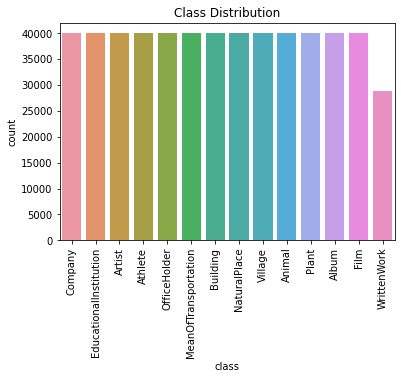

In [11]:
# plot class distribution
plot_class_distribution(data, class_lookup)

**Observations**

  - Class distribution of the dataset the classes are well balanced, which opens up the options of the ml algorithms we can use which are relatively more sensitive to class imbalance (e.g. Neural Nets).
  - Additional we can notice that there is no outside class, this is convinient as we dont have to worry about removing this from the evaluation stage. However, the outside class is useful for learning as it allows the classifier to better refine decision boundaries and also have a bucket for classifying words that are not within the entities we are interested in. 
  

## Token Freq Distribution

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import nltk
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [13]:
def tokenize_data(names):
    tokens = [token.lower() for token in word_tokenize(" ".join(names))]
    return tokens


In [14]:
tokens = tokenize_data(data['Name'].values)

In [15]:
def plot_word_distribution(tokens, title="Token Distribution"):
    """plots class distribution"""
    # class counts
    token_count = Counter(tokens)
    tokens_counts_df = pd.DataFrame(token_count, index=range(1)).T
    tokens_counts_df = tokens_counts_df.reset_index()
    tokens_counts_df.columns = ['token', 'count']
    tokens_counts_df.sort_values(by='count', inplace=True, ascending=False)
    sns.barplot(data=tokens_counts_df[:60], x='token', y='count', label="Total")
    plt.title(title)
    plt.xticks(rotation=90)

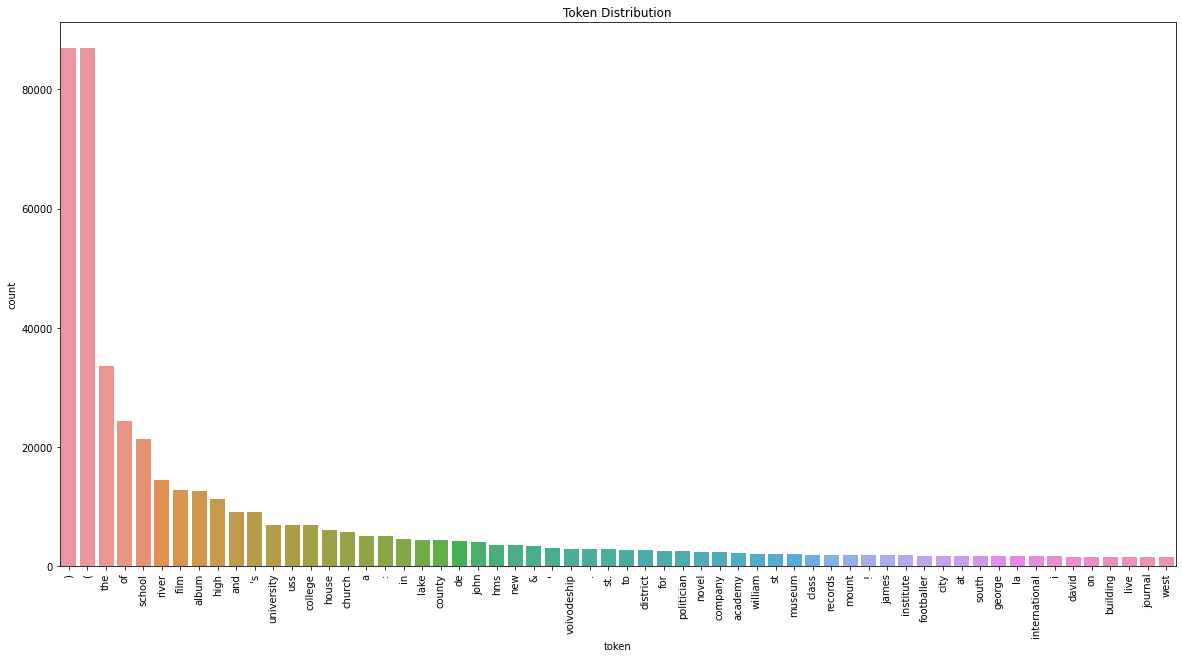

In [16]:
plot_word_distribution(tokens)

**Observations:**

 - The most common token is a bracket - so we will need to include these as stopwords. This will reduce the level of clutter in the names and make it easier for the model to focus on the descriminative property of characters sequences. 
 - Because we are dealing with short names, we might also want to keep some tokens such as 'a', 'at'. This is purely because transformer blocks have self-attension layers which enables them to attend/weight stopwords such as 'a', 'at', 'an' accordindly. (Attension is all you need, 2017).
    

## Dates and Numbers
Another thing we can look into is tokens of numeric form. Ideally we will want to replace numeric forms such as dates e.g. 1970 with a reserved token such as "\<DATE>", and arbitrary numbers with a representation such as "\<Number>". This reduces the dimensionality of the vocabulary needed to describe text by abstracting away some from numbers into "meta tokens". 

In [17]:
numeric_tokens = [token for token in tokens if token.isnumeric()]

In [18]:
# date check function 
is_date =  lambda token:  token.isnumeric() and len(token) == 4 and int(token) < 2999
# is numeric token 
is_other_numeric = lambda token: token.isnumeric() and len(token) != 4 

In [19]:
date_tokens = [token for token in tokens if is_date(token)]

In [20]:
date_tokens[:10]

['1992',
 '1946',
 '1776',
 '1905',
 '2010',
 '1616',
 '1921',
 '1963',
 '1920',
 '1995']

In [21]:
print(f'number of date tokens: {len(date_tokens)}')

number of date tokens: 13577


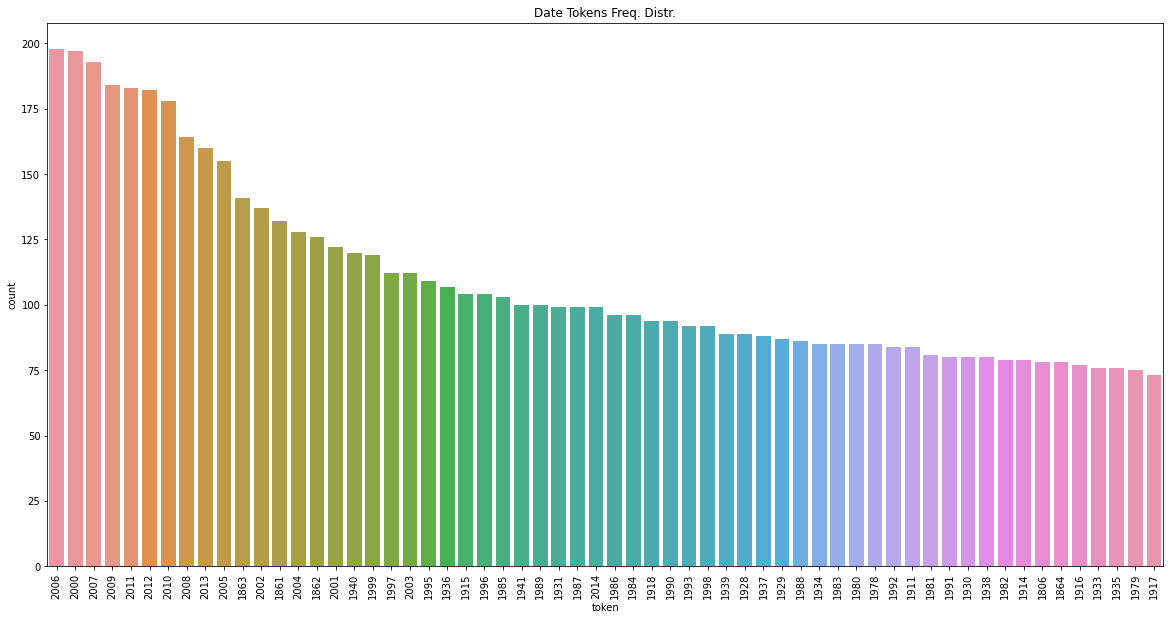

In [22]:
plot_word_distribution(date_tokens, "Date Tokens Freq. Distr.")

In [23]:
numeric_tokens = [token for token in tokens if is_other_numeric(token)]

In [24]:
numeric_tokens[:10]

['6', '1', '54', '4', '888', '100', '1', '24', '44', '43']

In [25]:
print(f'number of numeric tokens: {len(numeric_tokens)}')

number of numeric tokens: 7561


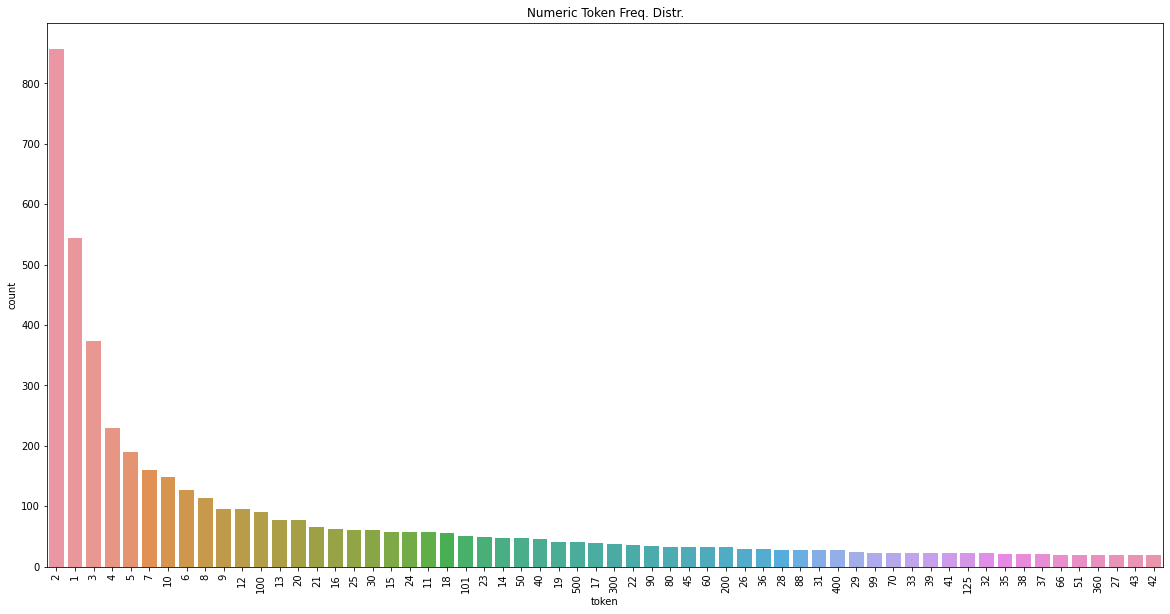

In [26]:
plot_word_distribution(numeric_tokens, "Numeric Token Freq. Distr.")

**Observations**
- Numeric tokens account for 7.6k of the tokens. This reduces the dimensionality of that space into just one meta-token.
- Dates account for more, with 15.6K of the tokens. This will also significantly reduce the dimensionality of the date space to be mapped to one meta-token. 


## Non-Alphanumeric Characters
The dataset contains brackets which as highlighted in the read.

In [27]:
is_not_alphanumeric = lambda token: not(token.isalnum())
# non-alphanumeric tokens
non_alpha_numeric_tokens = [token for token in tokens if is_not_alphanumeric(token)]

In [28]:
non_alpha_numeric_tokens[:10]

['e.',
 'd.',
 'schwan-stabilo',
 'q-workshop',
 '(',
 ')',
 'i-innovate',
 '(',
 ')',
 '&']

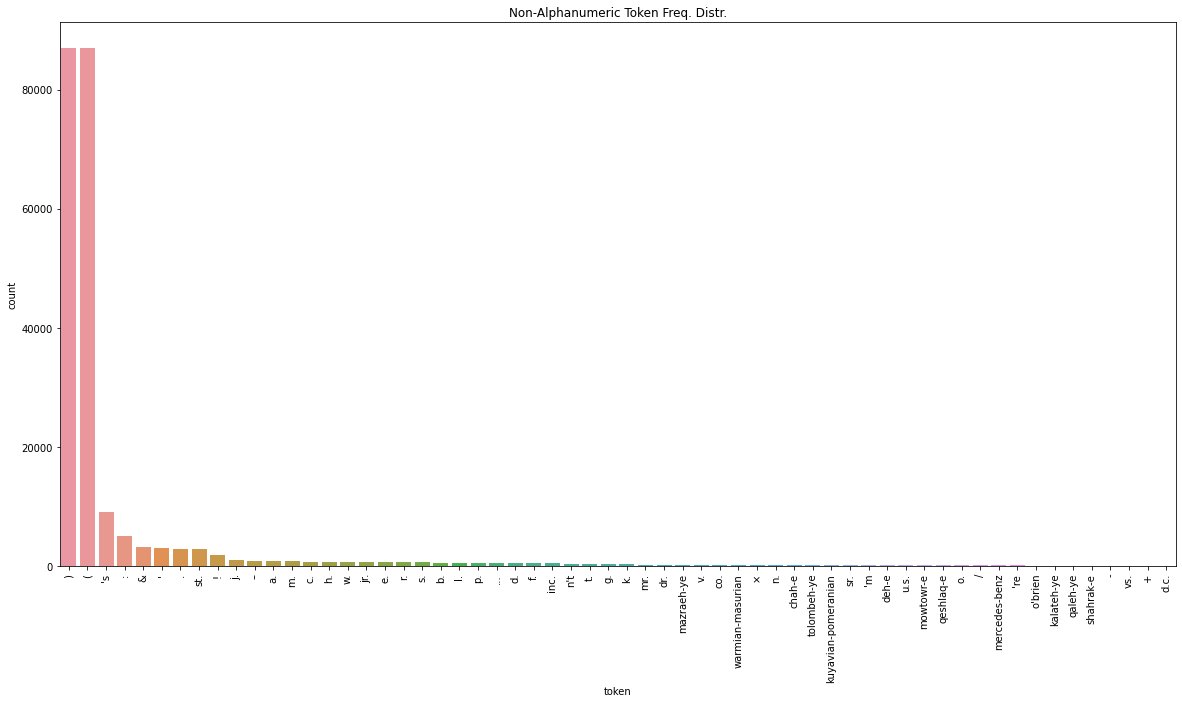

In [29]:
plot_word_distribution(non_alpha_numeric_tokens, "Non-Alphanumeric Token Freq. Distr.")

**Observations:**
    
- Brackets make up a majority of the non-alphanumeric tokens and will need to be cleaned up as part of the preprocessing step.
- We could also consider groupping other tokens such as '&' can be mapped to the token 'and' to further reduce the the dimensionality of the vocabulary set.

## Discriminative Tokens

In [30]:
# Here we subsample the dataset in order to be able to get analyse joint distributions of tokens and classes
dataset_subsample = data.sample(10000)

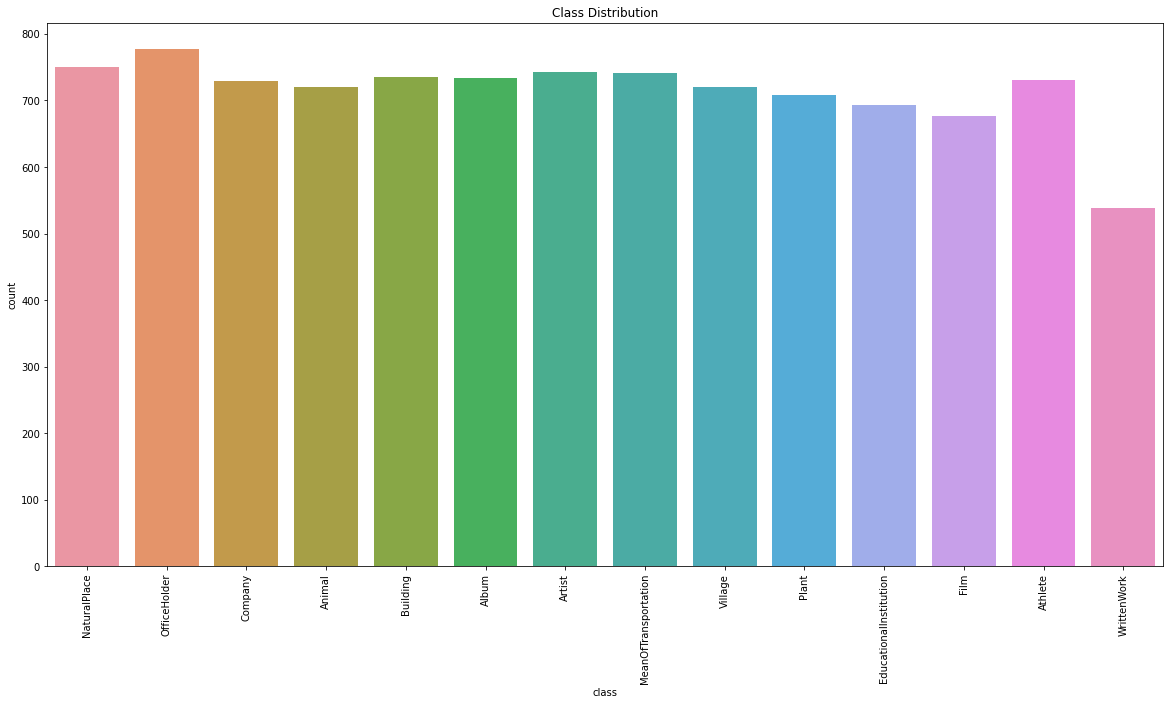

In [31]:
plot_class_distribution(dataset_subsample,class_lookup)

In order to determin discrimative tokens and also to simplify the representation in favour of building an intuition and understanding, we will be using a count vectorizer to produce binary feature vectors for the names represented as bi-grams. In addition we will be using a fitted decision tree to extract feature importance.

In [32]:
def preprocessor(token):
    """preprocess"""
    return token.lower().strip()

count_vectorizer_params = {
    'analyzer': 'word',
    'binary': True,
    'ngram_range': (1,2),
    'tokenizer': word_tokenize,
    'preprocessor': preprocessor,
    'stop_words': [')', '(', '.', ':', '.'],
    'lowercase': True,
    'strip_accents': 'unicode',
    'encoding': 'utf-8'
}

count_vectorizer = CountVectorizer(**count_vectorizer_params)

In [33]:
binary_representation = count_vectorizer.fit_transform(dataset_subsample['Name'].values)

In [34]:
binary_representation

<10000x30249 sparse matrix of type '<class 'numpy.int64'>'
	with 45161 stored elements in Compressed Sparse Row format>

In [35]:
vocabulary = count_vectorizer.vocabulary_.keys()

In [36]:
print(f'vocabulary size: {len(vocabulary)}')

vocabulary size: 30249


In [37]:
# here we convert the sparse representation meant to reseve space into a dense matrix of the binary feature representation of our dataset
binary_repr_df = pd.DataFrame(binary_representation.todense())
binary_repr_df.columns = vocabulary

In [38]:
binary_repr_df.head()

,khuruña,cecil,bothwell,cecil bothwell,shimano,düssi,neocomitidae,eucereon,costulata,eucereon costulata,...,next media,chin,valentine chin,beckford,hms beckford,monona,monona county,licania,rigida,licania rigida
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datetime import datetime
import time

def create_dct_pipeline():
    """
    dct pipeline
    
    We are defining a DCT model with entropy as the measurement criterion for splitting nodes. This 
    """
    dct_params = {
        "criterion": "entropy",
        "splitter": "best",
        "min_samples_split": 5,
        "min_samples_leaf": 5
    }
    dct = ('Decision Tree', DecisionTreeClassifier(**dct_params))
    
    return Pipeline(steps=[dct])


def fit_and_evalaute(model_pipeline, X, y, target_var, save=False, name='dct_pipeline'):
    """
    Fits a model to the given training set and evalutes its performance
    
    params:
        -model_pipeline 
    
    """
    start = time.time()
    X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    
    if save:
        timestamp = datetime.now()
        X_train.join(y_tain).to_csv(f'{name}_{target_var}_{timestamp}.csv')
        X_test.join(y_test).to_csv(f'{name}_{target_var}_{timestamp}.csv')
    
    # fit model
    fitted_model = model_pipeline.fit(X_train, y_train)
    
    # predict on test
    y_pred = fitted_model.predict(X_test)
    
    # evaluate model
    class_report = classification_report(y_true=y_test, y_pred=y_pred)
    
    print(class_report)
    print(f'Took: {time.time() - start} seconds')
    return fitted_model


In [111]:
dct_pipeline = create_dct_pipeline()

In [113]:
X = binary_repr_df.values
y = dataset_subsample['Class'].values

# fit and evaluate
fitted_model = fit_and_evalaute(dct_pipeline, X=X, y=y, target_var='class')

              precision    recall  f1-score   support

           1       0.77      0.15      0.26       221
           2       0.93      0.88      0.91       219
           3       0.44      0.10      0.16       209
           4       0.59      0.12      0.20       217
           5       0.52      0.22      0.31       239
           6       0.99      0.42      0.59       246
           7       0.91      0.53      0.67       202
           8       0.98      0.59      0.73       257
           9       0.76      0.20      0.31       193
          10       0.13      0.98      0.23       220
          11       0.84      0.07      0.13       222
          12       0.53      0.47      0.50       208
          13       0.79      0.37      0.51       185
          14       0.45      0.48      0.46       162

    accuracy                           0.40      3000
   macro avg       0.69      0.40      0.43      3000
weighted avg       0.70      0.40      0.43      3000

Took: 189.4634931087494 s

In [118]:
def get_dct_from_pipeline(pipeline):
    """returns decision tree classifier from withing a classifier"""
    
    if not isinstance(pipeline, Pipeline):
        raise Exception(f"Expected pipeline as input but got an object of type {type(pipeline)}")
    
    for step in pipeline.steps:
        if isinstance(step[1], DecisionTreeClassifier):
            return step[1]
    return None

In [139]:
def plot_feature_importance(dct_pipeline, vocab, top_n=50):
    dct_model = get_dct_from_pipeline(dct_pipeline)
    
    if dct_model is None:
        raise Exception(f"Expected a Decisiont Tree Classifier in the pipeline but found none")
    
    feat_importance = dct_model.feature_importances_
    feat_importance_df = pd.DataFrame(feat_importance).T
    feat_importance_df.columns = vocab
    
    feat_importance_df = feat_importance_df.T
    feat_importance_df.reset_index(inplace=True)
    feat_importance_df.columns = ['token', 'importance']
    
    feat_importance_df.sort_values(by='importance', ascending=False, inplace=True)
    
    sns.barplot(data=feat_importance_df[:top_n], x='token', y='importance', label="Importance")
    plt.title(f"Top {top_n} Feature Importance")
    plt.xticks(rotation=90)

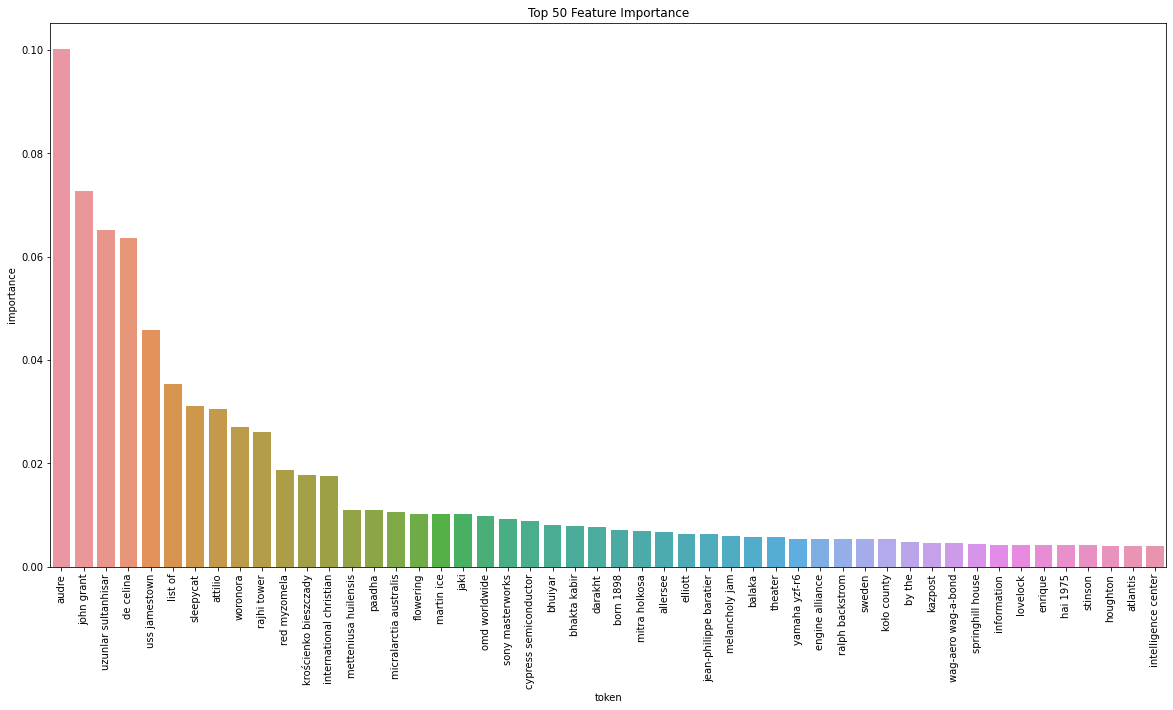

In [140]:
plot_feature_importance(fitted_model,vocabulary )